In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2Repo
!pip install -e detectron2Repo

fatal: destination path 'detectron2Repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2Repo
  Found existing installation: detectron2 0.2.1
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [ ]:
!pip install -U torch torchvision
!!pip install git+https://github.com/facebookresearch/fvcore.git

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)


['Collecting git+https://github.com/facebookresearch/fvcore.git',
 '  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-zoju81f2',
 '  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-zoju81f2',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.6/dist-packages (from fvcore==0.1.2) (1.18.5)',
 'Requirement already satisfied: yacs>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from fvcore==0.1.2) (0.1.8)',
 'Collecting pyyaml>=5.1',
 '\x1b[?25l  Downloading https://files.pythonhosted.org/packages/64/c2/b80047c7ac2478f9501676c988a5411ed5572f35d1beff9cae07d321512c/PyYAML-5.3.1.tar.gz (269kB)',
 '',
 '\x1b[K     |█▏                              | 10kB 20.6MB/s eta 0:00:01',
 '\x1b[K     |██▍                             | 20kB 20.1MB/s eta 0:00:01',
 '\x1b[K     |███▋                            | 30kB 16.3MB/s eta 0:00:01',
 '\x1b[K     |████▉                           | 40kB 14.3MB/s eta 0:00:01',
 '\

In [ ]:
import torch, torchvision
torch.__version__

'1.6.0+cu101'

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!unzip ./train.zip -d rokok/
!unzip ./val.zip -d rokok/

Streaming output truncated to the last 5000 lines.
  inflating: rokok/train/c8.jpg      
  inflating: rokok/train/c80.jpg     
  inflating: rokok/train/c800.jpg    
  inflating: rokok/train/c801.jpg    
  inflating: rokok/train/c802.jpg    
  inflating: rokok/train/c803.jpg    
  inflating: rokok/train/c804.jpg    
  inflating: rokok/train/c805.jpg    
  inflating: rokok/train/c806.jpg    
  inflating: rokok/train/c807.jpg    
  inflating: rokok/train/c808.jpg    
  inflating: rokok/train/c809.jpg    
  inflating: rokok/train/c81.jpg     
  inflating: rokok/train/c810.jpg    
  inflating: rokok/train/c811.jpg    
  inflating: rokok/train/c812.jpg    
  inflating: rokok/train/c813.jpg    
  inflating: rokok/train/c814.jpg    
  inflating: rokok/train/c815.jpg    
  inflating: rokok/train/c816.jpg    
  inflating: rokok/train/c817.jpg    
  inflating: rokok/train/c818.jpg    
  inflating: rokok/train/c819.jpg    
  inflating: rokok/train/c82.jpg     
  inflating: rokok/train/c820.jpg    

In [ ]:
# !unzip ./val2.zip -d rokok/

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("rokokTrain", {}, "rokok/train/trainMk3c1071.json", "rokok/train")
register_coco_instances("rokokVal", {}, "rokok/val/valMk3.json", "rokok/val")

In [ ]:
fruits_nuts_metadata = MetadataCatalog.get("rokokTrain")
dataset_dicts = DatasetCatalog.get("rokokTrain")
val_dicts = DatasetCatalog.get("rokokVal")

[10/26 01:53:01 d2.data.datasets.coco]: Loaded 5937 images in COCO format from rokok/train/trainMk3c1071.json
[10/26 01:53:01 d2.data.datasets.coco]: Loaded 1487 images in COCO format from rokok/val/valMk3.json


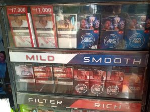

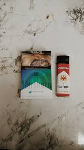

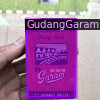

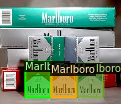

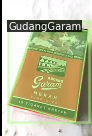

In [ ]:
import random

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2Repo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("rokokTrain",)
cfg.DATASETS.TEST = ("rokokVal",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02

cfg.STEPS = (1000, )
cfg.SOLVER.MAX_ITER = 20000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 4 classes (djarum, sampoerna, gudanggaram, marlboro)
cfg.TEST.EVAL_PERIOD = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/26 01:53:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl: 431MB [00:19, 22.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[10/26 01:53:39 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2Repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2Repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2Repo/detectron2/layers/wrappers.py:125: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unb

[10/26 01:54:01 d2.utils.events]:  eta: 5:47:12  iter: 19  total_loss: 1.737  loss_cls: 0.8336  loss_box_reg: 0.1399  loss_mask: 0.6294  loss_rpn_cls: 0.005251  loss_rpn_loc: 0.007762  time: 1.0791  data_time: 0.0143  lr: 0.00039962  max_mem: 5674M
[10/26 01:54:25 d2.utils.events]:  eta: 5:57:12  iter: 39  total_loss: 0.6571  loss_cls: 0.137  loss_box_reg: 0.1308  loss_mask: 0.3146  loss_rpn_cls: 0.004851  loss_rpn_loc: 0.004274  time: 1.1516  data_time: 0.0080  lr: 0.00079922  max_mem: 6155M
[10/26 01:54:54 d2.utils.events]:  eta: 6:49:48  iter: 59  total_loss: 0.6508  loss_cls: 0.2028  loss_box_reg: 0.2035  loss_mask: 0.1994  loss_rpn_cls: 0.006021  loss_rpn_loc: 0.006642  time: 1.2467  data_time: 0.0086  lr: 0.0011988  max_mem: 6155M
[10/26 01:55:23 d2.utils.events]:  eta: 7:15:35  iter: 79  total_loss: 0.4688  loss_cls: 0.1513  loss_box_reg: 0.1817  loss_mask: 0.1296  loss_rpn_cls: 0.00598  loss_rpn_loc: 0.01159  time: 1.3052  data_time: 0.0069  lr: 0.0015984  max_mem: 6155M
[10/26

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("rokokTrain", )
predictor = DefaultPredictor(cfg)

In [ ]:
!unzip ./testPhoto.zip -d rokok/

In [ ]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("rokok/testPhoto/test8.jpg")
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=fruits_nuts_metadata,
                    scale=0.8,
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.utils.visualizer import ColorMode

for(i=0;i<=8;i++){
    im = cv2.imread("rokok/testPhoto/test"+i+".jpg")
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=fruits_nuts_metadata,
                    scale=0.8,
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
}

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dicts, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
!zip -r "/content/outputMk13.zip" "/content/output"
!zip -r "/content/outputMk13.zip" "/content/coco_eval"

In [ ]:
!cp /content/outputMk13.zip /content/drive/My\ Drive/rcnn/